In [6]:
import env
import utilities as utils

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from wrangle_zillow import wrangle_zillow_data
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

In [7]:
_zillow_query = """
SELECT prop.*, 
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 
FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
       					  logerror,
                          Max(transactiondate) transactiondate 
                   FROM   predictions_2017 
                   GROUP  BY parcelid, logerror) pred
               USING (parcelid) 
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL
"""


In [8]:
zillow_df = utils.generate_df("zillow.csv", _zillow_query, utils.generate_db_url(env.user, env.password, env.host, "zillow"))

In [ ]:
zillow_df.head(5)

In [ ]:
zillow_df.sample(15)

In [ ]:
zillow_df.info()

In [ ]:
zillow_df.describe()

In [ ]:
#Prepare 
def drop_unnecessary_columns(zillow_df):
    """
    Takes in the zillow data frame and removes any columns deemed unnecessary or those that do not meet the population thresholds. Returns a       copy of the data frame without those columns.
    """
    df = zillow_df.copy()
    
    df = utils.handle_missing_values(df, .6, .4)
    drop_cols = ['id', 'parcelid', 'finishedsquarefeet12', 'fullbathcnt', 'propertylandusetypeid', 'heatingorsystemtypeid', 'censustractandblock', 'rawcensustractandblock', 'regionidzip', 'assessmentyear', 'regionidcounty', 'yearbuilt', 'roomcnt']
    
    return df.drop(columns=drop_cols)

def handle_missing_zillow_values(zillow_df):
    """
    Takes in the zillow data frame and fills the NaN values with either the mode or the median of the column. Returns a copy of the data frame     with the filled in values.
    """
    df = zillow_df.copy()
    
    df['buildingqualitytypeid'].fillna(value=8.0, inplace=True)    
    df['calculatedbathnbr'].fillna(value=2.0, inplace=True)
    df['calculatedfinishedsquarefeet'].fillna(value=1542, inplace=True)
    df['lotsizesquarefeet'].fillna(value=7205, inplace=True)
    df['propertyzoningdesc'].fillna(value="LAR1", inplace=True)
    df['regionidcity'].fillna(value=12447, inplace=True)
    df['regionidzip'].fillna(value=97319, inplace=True)
    df['unitcnt'].fillna(value=1, inplace=True)
    df['yearbuilt'].fillna(value=1970, inplace=True)
    df['structuretaxvaluedollarcnt'].fillna(value=136399.0, inplace=True)
    df['heatingorsystemdesc'].fillna(value='Central', inplace=True)
    df['taxamount'].fillna(value=4447.63, inplace=True)
    df['taxvaluedollarcnt'].fillna(value=358879, inplace=True)
    df['landtaxvaluedollarcnt'].fillna(value=203174, inplace=True)
    
    return df

def rename_zillow_columns(zillow_df):
    """
    Takes in the zillow data frame and renames the columns. Returns a copy of the data frame with the renamed columns.
    """
    df = zillow_df.copy()
    
    rename_dict = {'bathroomcnt' : 'bathrooms', 'bedroomcnt' : 'bedrooms', 'buildingqualitytypeid' : 'build_quality', 'calculatedbathnbr' : 'fractional_bathrooms', 'calculatedfinishedsquarefeet' : 'sqft', 'lotsizesquarefeet' : 'lot_size', 'propertycountylandusecode' : 'land_use_code', 'propertyzoningdesc' : 'zoning_desc', 'regionidcity' : 'city_id', 'unitcnt' : 'units', 'structuretaxvaluedollarcnt' : 'structure_tax_value', 'taxvaluedollarcnt' : 'tax_value', 'landtaxvaluedollarcnt' : 'land_tax_value', 'taxamount' : 'tax_amount', 'logerror' : 'error', 'transactiondate' : 'transaction_date', 'heatingorsystemdesc' : 'heat_system_desc', 'propertylandusedesc' : 'property_land_use_desc'}
    
    return df.rename(columns=rename_dict)

def encode_zillow_categoricals(zillow_df):
    """
    Takes in the zillow data frame and encodes the categorical variables. Returns a copy of the data frame with the encoded columns.
    """
    df = zillow_df.copy()

    fips_dummies = pd.get_dummies(df.fips, dummy_na=False, drop_first=True)
    heat_dummies = pd.get_dummies(df.heat_system_desc, dummy_na=False, drop_first=True)
    prop_use_dummies = pd.get_dummies(df.property_land_use_desc, dummy_na=False, drop_first=True)
    
    return pd.concat([df, fips_dummies, heat_dummies, prop_use_dummies], axis=1)

def add_zillow_features(zillow_df):
    """
    Takes in the zillow data frame and adds engineered features. Returns a copy of the dataframe with the new features.
    """
    df = zillow_df.copy()
    
    df['age'] = 2017 - df['yearbuilt']
    
    return df

def remove_zillow_outliers(zillow_df):
    """
    Takes in the zillow data frame and removes outliers above the determined upper bound. Returns a copy of the data frame with the outliers       removed.
    """
    df = zillow_df.copy()
    cont_vars = ['bathrooms', 'bedrooms', 'fractional_bathrooms', 'sqft', 'lot_size', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount', 'error']

    for var in cont_vars:
        upper_bound, lower_bound = utils.generate_outlier_bounds(df, var, 3)  
        df = df[(df[var] > lower_bound) & (df[var] < upper_bound)]
    
    return df
    

In [ ]:
utils.show_missing_value_stats_by_col(zillow_df)

In [ ]:
utils.show_missing_value_stats_by_row(zillow_df)

In [ ]:
drop_missing_zillow = utils.handle_missing_values(zillow_df.copy(), .6, .4)
drop_missing_zillow.head()

In [ ]:
drop_missing_zillow.info()

In [ ]:
drop_missing_zillow.shape

In [ ]:
utils.show_missing_value_stats_by_col(drop_missing_zillow)

In [ ]:
drop_missing_zillow['buildingqualitytypeid'].value_counts()

In [ ]:
drop_missing_zillow['buildingqualitytypeid'].fillna(value=8.0, inplace=True)


In [ ]:
drop_missing_zillow['buildingqualitytypeid'].value_counts()


In [ ]:
drop_missing_zillow['calculatedbathnbr'].median()


In [ ]:
drop_missing_zillow['calculatedbathnbr'].fillna(value=2.0, inplace=True)



In [ ]:
drop_missing_zillow['calculatedfinishedsquarefeet'].median()


In [ ]:
drop_missing_zillow['calculatedfinishedsquarefeet'].fillna(value=1542, inplace=True)


In [ ]:
utils.show_missing_value_stats_by_col(drop_missing_zillow)


In [ ]:
drop_cols = ['finishedsquarefeet12', 'fullbathcnt', 'propertylandusetypeid', 'heatingorsystemtypeid', 'censustractandblock']
drop_missing_zillow.drop(columns=drop_cols, inplace=True)

In [ ]:
utils.show_missing_value_stats_by_col(drop_missing_zillow)

In [ ]:
drop_missing_zillow['lotsizesquarefeet'].median()

In [ ]:
drop_missing_zillow['lotsizesquarefeet'].fillna(value=7205, inplace=True)

In [ ]:
drop_missing_zillow['propertyzoningdesc'].mode()

In [ ]:
drop_missing_zillow['propertyzoningdesc'].fillna(value='LAR1', inplace=True)

In [ ]:
drop_missing_zillow['regionidcity'].value_counts()

In [ ]:
drop_missing_zillow['regionidcity'].fillna(value=12447, inplace=True)

In [ ]:
utils.show_missing_value_stats_by_col(drop_missing_zillow)

In [ ]:
drop_missing_zillow['regionidzip'].value_counts()

In [ ]:
drop_missing_zillow['regionidzip'].fillna(value=97319, inplace=True)

In [ ]:
drop_missing_zillow['unitcnt'].value_counts()

In [ ]:
drop_missing_zillow['unitcnt'].fillna(value=1, inplace=True)

In [ ]:
utils.show_missing_value_stats_by_col(drop_missing_zillow)

In [ ]:
drop_missing_zillow['yearbuilt'].median()

In [ ]:
drop_missing_zillow['yearbuilt'].fillna(value=1970, inplace=True)

In [ ]:
drop_missing_zillow['structuretaxvaluedollarcnt'].fillna(value=136399.0, inplace=True)

drop_missing_zillow['heatingorsystemdesc'].fillna(value='Central', inplace=True)

In [ ]:
utils.show_missing_value_stats_by_col(drop_missing_zillow)

In [ ]:
utils.show_missing_value_stats_by_row(drop_missing_zillow)

In [ ]:
drop_missing_zillow['taxamount'].fillna(value=4447.63, inplace=True)

In [ ]:
train, validate, test = wrangle_zillow_data()

In [ ]:
cat_vars = ['build_quality', 'fips', 'latitude', 'longitude', 'land_use_code', 'zoning_desc', 'city_id', 'county_id', 'transaction_date', 'heat_system_desc', 'property_land_use_desc']
cont_vars = ['bathrooms', 'bedrooms', 'fractional_bathrooms', 'sqft', 'lot_size', 'rooms', 'units', 'age', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount', 'error']

In [ ]:

train.shape

In [ ]:

utils.generate_outlier_bounds(train, 'error', 3)


In [ ]:
scale_vars = ['bathrooms', 'bedrooms', 'fractional_bathrooms', 'sqft', 'lot_size', 'units', 'age', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount']
train_scaled, validate_scaled, test_scaled = utils.generate_scaled_splits(train[scale_vars],validate[scale_vars], test[scale_vars], RobustScaler())

In [ ]:
train_scaled.head(5)

In [ ]:
train.head(5)

In [ ]:
# Credit to @magsguist
def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        _explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = _explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)

def explore_bivariate_categorical(target, cat_vars, train):
    """
    Takes in a target and plots it against categorial variables. Outputs boxplots and barplots and gives the mean of the target
    by each categorical variable.
    """
    for var in cat_vars:
        _print_header(var, target)

        sns.boxplot(x=var, y=target, data=train)
        plt.show()

        print()

        sns.barplot(x=var, y=target, data=train)
        plt.show()
        
        print("-------------------------------")
        print(f"Mean {target} by {var}:  ")
        print(train.groupby(var)[target].mean())
        print()

def explore_bivariate_continuous(target, cont_vars, train):
    """
    Takes in a target and plots it against continuous variables. Outputs a relplot and calculates the corrleation value between
    the target and each continuous variable.
    """
    for var in cont_vars:
        _print_header(var, target)
        
        sns.relplot(x=var, y=target, data=train)
        plt.show()
        corr, p = stats.pearsonr(train[var], train[target])
        
        print("-------------------------------")
        print(f"Correlation between {var} and {target}:  {corr}")
        print(f"P value:  {p}")
        print()

def explore_multivariate_(cont_vars, cat_vars, target, train):
    """
    Takes in a target and continuous and categorical variables. Outputs a relplot of each continuous variable against the target
    with each categorical varible as the hue.
    """
    for cont_var in cont_vars:
        _print_header(cont_var, target)
        
        for cat_var in cat_vars:
            sns.relplot(x=cont_var, y=target, hue=cat_var, data=train)
            plt.title(f"By {cat_var}")
            plt.show()
            print()

def _print_header(var, target):
    print(f"{var} vs {target}")
    print("-------------------------------")

@DeprecationWarning
def explore_bivariate(train, target, cat_vars, quant_vars):
    for cat in cat_vars:
        _explore_bivariate_categorical(train, target, cat)
    for quant in quant_vars:
        _explore_bivariate_quant(train, target, quant)

@DeprecationWarning
def explore_multivariate(train, target, cat_vars, quant_vars):
    '''
    '''
    _plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    _plot_violin_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    sns.pairplot(data=train, vars=quant_vars, hue=target)
    plt.show()
    _plot_all_continuous_vars(train, target, quant_vars)
    plt.show()    


### Univariate

def _explore_univariate_categorical(train, cat_var):
    '''
    takes in a dataframe and a categorical variable and returns
    a frequency table and barplot of the frequencies. 
    '''
    frequency_table = _freq_table(train, cat_var)
    plt.figure(figsize=(2,2))
    sns.barplot(x=cat_var, y='Count', data=frequency_table, color='lightseagreen')
    plt.title(cat_var)
    plt.show()
    print(frequency_table)

def _explore_univariate_quant(train, quant_var):
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='lightseagreen')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats
    
def _freq_table(train, cat_var):
    '''
    for a given categorical variable, compute the frequency count and percent split
    and return a dataframe of those values along with the different classes. 
    '''
    class_labels = list(train[cat_var].unique())

    frequency_table = (
        pd.DataFrame({cat_var: class_labels,
                      'Count': train[cat_var].value_counts(normalize=False), 
                      'Percent': round(train[cat_var].value_counts(normalize=True)*100,2)}
                    )
    )
    return frequency_table


#### Bivariate

def _explore_bivariate_categorical(train, target, cat_var):
    '''
    takes in categorical variable and binary target variable, 
    returns a crosstab of frequencies
    runs a chi-square test for the proportions
    and creates a barplot, adding a horizontal line of the overall rate of the target. 
    '''
    print(cat_var, "\n_____________________\n")
    ct = pd.crosstab(train[cat_var], train[target], margins=True)
    chi2_summary, observed, expected = _run_chi2(train, cat_var, target)
    p = _plot_cat_by_target(train, target, cat_var)
    
    print(chi2_summary)
    print("\nobserved:\n", ct)
    print("\nexpected:\n", expected)
    plt.show(p)
    print("\n_____________________\n")

def _explore_bivariate_quant(train, target, quant_var):
    '''
    descriptive stats by each target class. 
    compare means across 2 target groups 
    boxenplot of target x quant
    swarmplot of target x quant
    '''
    print(quant_var, "\n____________________\n")
    descriptive_stats = train.groupby(target)[quant_var].describe()
    average = train[quant_var].mean()
    mann_whitney = _compare_means(train, target, quant_var)
    plt.figure(figsize=(4,4))
    boxen = _plot_boxen(train, target, quant_var)
    swarm = _plot_swarm(train, target, quant_var)
    plt.show()
    print(descriptive_stats, "\n")
    print("\nMann-Whitney Test:\n", mann_whitney)
    print("\n____________________\n")

## Bivariate Categorical

def _run_chi2(train, cat_var, target):
    observed = pd.crosstab(train[cat_var], train[target])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    chi2_summary = pd.DataFrame({'chi2': [chi2], 'p-value': [p], 
                                 'degrees of freedom': [degf]})
    expected = pd.DataFrame(expected)
    return chi2_summary, observed, expected

def _plot_cat_by_target(train, target, cat_var):
    p = plt.figure(figsize=(2,2))
    p = sns.barplot(cat_var, target, data=train, alpha=.8, color='lightseagreen')
    overall_rate = train[target].mean()
    p = plt.axhline(overall_rate, ls='--', color='gray')
    return p
    

## Bivariate Quant

def _plot_swarm(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.swarmplot(data=train, x=target, y=quant_var, color='lightgray')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

def _plot_boxen(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.boxenplot(data=train, x=target, y=quant_var, color='lightseagreen')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

# alt_hyp = ‘two-sided’, ‘less’, ‘greater’

def _compare_means(train, target, quant_var, alt_hyp='two-sided'):
    x = train[train[target]==0][quant_var]
    y = train[train[target]==1][quant_var]
    return stats.mannwhitneyu(x, y, use_continuity=True, alternative=alt_hyp)


### Multivariate

def _plot_all_continuous_vars(train, target, quant_vars):
    '''
    Melt the dataset to "long-form" representation
    boxenplot of measurement x value with color representing survived. 
    '''
    my_vars = [item for sublist in [quant_vars, [target]] for item in sublist]
    sns.set(style="whitegrid", palette="muted")
    melt = train[my_vars].melt(id_vars=target, var_name="measurement")
    plt.figure(figsize=(8,6))
    p = sns.boxenplot(x="measurement", y="value", hue=target, data=melt)
    p.set(yscale="log", xlabel='')    
    plt.show()

def _plot_violin_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.violinplot(x=cat, y=quant, data=train, split=True, 
                           ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()
    
def _plot_swarm_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.swarmplot(x=cat, y=quant, data=train, ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()



In [ ]:
train.error.describe()

In [ ]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

In [ ]:
train.info()

In [ ]:
train.hist(figsize=[20,20])

In [ ]:
train.shape, validate.shape, test.shape

In [ ]:
#correlation heatmap
corr = pd.DataFrame(train.corr()['error'].sort_values(ascending = False)).rename(columns = {'error':'correlation'})

plt.figure(figsize = (4,8))
sns.heatmap(corr, annot = True, fmt = '.2f', vmin = -0.05, vmax = 0.05, cmap = 'magma')
plt.title('Correlation heatmap', fontsize = 15)
plt.show()

In [ ]:
sns.catplot(data=train, x='bedrooms',y='error', palette='flare',order=[1.0,2.0,3.0,4.0,5.0,6.0,7.0])

In [ ]:
sns.catplot(data=train, x='bathrooms',y='error', palette='crest',order=[1.0,2.0,3.0,4.0,5.0,])

In [ ]:
X_train = train_scaled
y_train = zillow_df[['error']]

In [3]:
train, validate, test = wrangle_zillow_data()

In [10]:
cat_vars = ['build_quality', 'fips', 'latitude', 'longitude', 'land_use_code', 'zoning_desc', 'city_id', 'county_id', 'transaction_date', 'heat_system_desc', 'property_land_use_desc']
cont_vars = ['bathrooms', 'bedrooms', 'fractional_bathrooms', 'sqft', 'lot_size', 'rooms', 'units', 'age', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount', 'error']

In [12]:
test.shape

(12018, 45)

In [14]:
cat_vars = ['build_quality', 'fips']
quant_vars = ['bathrooms', 'bedrooms', 'sqft', 'lot_size', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount', 'age']

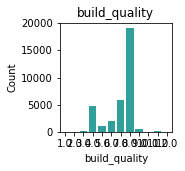

      build_quality  Count  Percent
8.0             8.0  19052    56.62
6.0             7.0   5823    17.31
4.0             4.0   4776    14.19
7.0             6.0   2087     6.20
5.0             5.0   1002     2.98
9.0             9.0    593     1.76
3.0             3.0    149     0.44
11.0           11.0    130     0.39
10.0           12.0     22     0.07
1.0             2.0      8     0.02
12.0           10.0      4     0.01
2.0             1.0      3     0.01
_________________________________________________________________


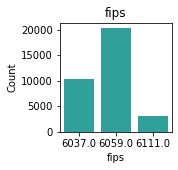

          fips  Count  Percent
6037.0  6059.0  20269    60.24
6059.0  6037.0  10314    30.65
6111.0  6111.0   3066     9.11
_________________________________________________________________


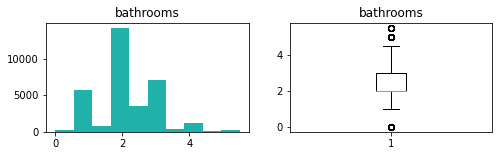

count    33649.000000
mean         2.196291
std          0.821414
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          5.500000
Name: bathrooms, dtype: float64


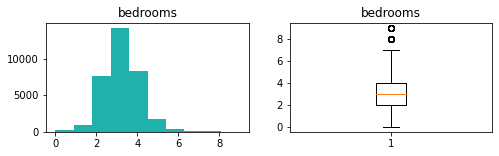

count    33649.000000
mean         3.095991
std          1.035450
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: bedrooms, dtype: float64


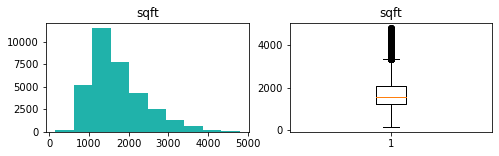

count    33649.000000
mean      1704.768463
std        695.296744
min        152.000000
25%       1208.000000
50%       1542.000000
75%       2058.000000
max       4793.000000
Name: sqft, dtype: float64


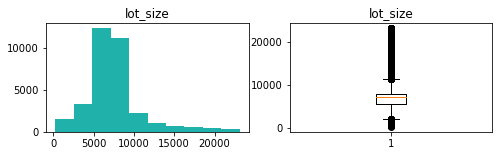

count    33649.000000
mean      7386.990282
std       3519.984121
min        236.000000
25%       5601.000000
50%       7040.000000
75%       7890.000000
max      23134.000000
Name: lot_size, dtype: float64


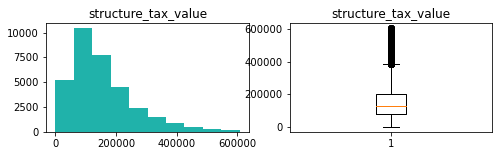

count     33649.000000
mean     155468.024310
std      105660.369843
min          44.000000
25%       79674.000000
50%      128990.000000
75%      203070.000000
max      608096.000000
Name: structure_tax_value, dtype: float64


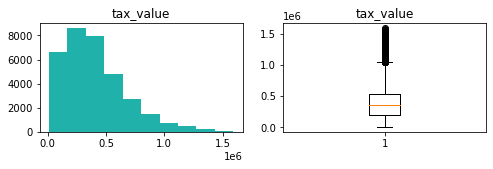

count    3.364900e+04
mean     4.022785e+05
std      2.691370e+05
min      9.242000e+03
25%      2.028420e+05
50%      3.530240e+05
75%      5.395490e+05
max      1.592248e+06
Name: tax_value, dtype: float64


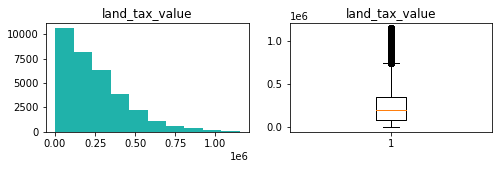

count    3.364900e+04
mean     2.469234e+05
std      2.036831e+05
min      1.627000e+03
25%      8.564000e+04
50%      2.033720e+05
75%      3.500000e+05
max      1.152511e+06
Name: land_tax_value, dtype: float64


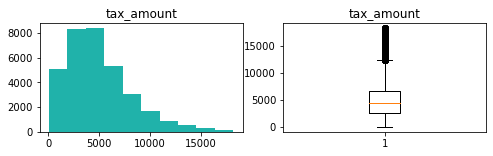

count    33649.000000
mean      4975.687311
std       3147.832687
min         49.180000
25%       2679.930000
50%       4385.900000
75%       6562.920000
max      18213.060000
Name: tax_amount, dtype: float64


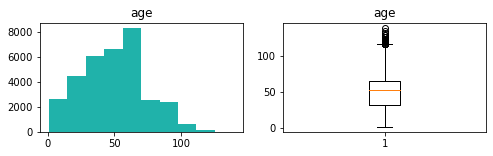

count    33649.000000
mean        49.968825
std         23.765071
min          1.000000
25%         31.000000
50%         52.000000
75%         65.000000
max        139.000000
Name: age, dtype: float64


In [15]:
utils.explore_univariate(train, cat_vars, quant_vars)

(array([  215.,  5757.,   754., 14200.,  3483.,  7164.,   429.,  1255.,
          150.,   242.]),
 array([0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 5.5 ]),
 <BarContainer object of 10 artists>)

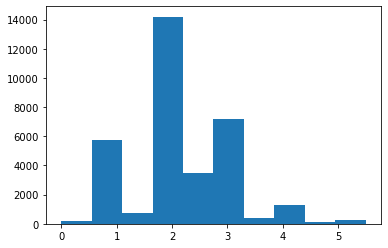

In [16]:
plt.hist(x='bathrooms', data=train)

In [ ]:
#Do properties with 2 bathrooms have a statistically different error than the population mean?

In [22]:
baths_2 = train[train.bathrooms == 2]

t, p = stats.ttest_1samp(baths_2.error, train.error.mean())
utils.evaluate_hypothesis_ttest(p, t, .05)

------------------------------------------
t:  -3.027958281588745, p:  0.0024665396972895735, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  
------------------------------------------


{'t': -3.027958281588745,
 'p': 0.0024665396972895735,
 'a': 0.05,
 'message': 'We reject the null hypothesis. We move forward with the alternative hypothesis:  ',
 'reject_null': True}

(array([  265.,   989.,  7669., 14157.,  8280.,  1763.,   364.,    57.,
           84.,    21.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

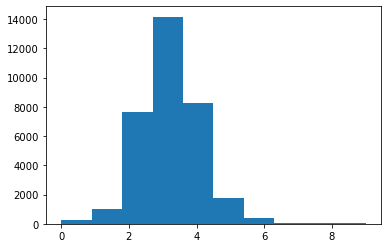

In [21]:
plt.hist(x='bedrooms', data=train)

In [ ]:
#Do properties with 3 bedrooms have a statistically different error than the population mean?

In [27]:
beds_3 = train[train.bedrooms == 3]

t, p = stats.ttest_1samp(beds_3.error, train.error.mean())
utils.evaluate_hypothesis_ttest(p, t, .05)

------------------------------------------
t:  -0.6872046338010408, p:  0.49196504252577833, a:  0.05

We fail to reject the null hypothesis:  
------------------------------------------


{'t': -0.6872046338010408,
 'p': 0.49196504252577833,
 'a': 0.05,
 'message': 'We fail to reject the null hypothesis:  ',
 'reject_null': False}

(array([20269.,     0., 10314.,     0.,     0.,     0.,     0.,     0.,
            0.,  3066.]),
 array([6037. , 6044.4, 6051.8, 6059.2, 6066.6, 6074. , 6081.4, 6088.8,
        6096.2, 6103.6, 6111. ]),
 <BarContainer object of 10 artists>)

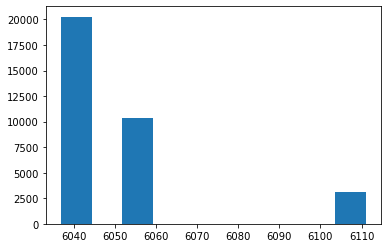

In [25]:
plt.hist(x='fips', data=train)


In [26]:
#Do properties in fips code 6059 have a statistically different error than the population mean?

In [28]:
fips_6059 = train[train.fips == 6059]

t, p = stats.ttest_1samp(fips_6059.error, train.error.mean())
utils.evaluate_hypothesis_ttest(p, t, .05)

------------------------------------------
t:  2.0092662655179483, p:  0.04453490999014401, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  
------------------------------------------


{'t': 2.0092662655179483,
 'p': 0.04453490999014401,
 'a': 0.05,
 'message': 'We reject the null hypothesis. We move forward with the alternative hypothesis:  ',
 'reject_null': True}

In [29]:
#Do properties in fips code 6037 have a statistically different error than the population mean?

In [30]:
fips_6037 = train[train.fips == 6037]

t, p = stats.ttest_1samp(fips_6037.error, train.error.mean())
utils.evaluate_hypothesis_ttest(p, t, .05)

------------------------------------------
t:  -2.037933263568385, p:  0.04156956419908872, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  
------------------------------------------


{'t': -2.037933263568385,
 'p': 0.04156956419908872,
 'a': 0.05,
 'message': 'We reject the null hypothesis. We move forward with the alternative hypothesis:  ',
 'reject_null': True}

(array([ 5234., 10430.,  7776.,  4486.,  2443.,  1458.,   857.,   470.,
          311.,   184.]),
 array([4.400000e+01, 6.084920e+04, 1.216544e+05, 1.824596e+05,
        2.432648e+05, 3.040700e+05, 3.648752e+05, 4.256804e+05,
        4.864856e+05, 5.472908e+05, 6.080960e+05]),
 <BarContainer object of 10 artists>)

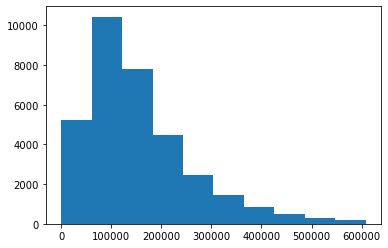

In [35]:
plt.hist(x='structure_tax_value', data=train)


In [31]:
# Do properties with a structure_tax_value of 130_000 have a have a statistically different error than the population mean?

In [34]:
stv_130k = train[train.structure_tax_value == 130_000]

t, p = stats.ttest_1samp(stv_130k.error, train.error.mean())
utils.evaluate_hypothesis_ttest(p, t, .05)

------------------------------------------
t:  0.19610965882594972, p:  0.8478061395059269, a:  0.05

We fail to reject the null hypothesis:  
------------------------------------------


{'t': 0.19610965882594972,
 'p': 0.8478061395059269,
 'a': 0.05,
 'message': 'We fail to reject the null hypothesis:  ',
 'reject_null': False}

In [ ]:
#Takeaways 